In [ ]:
pip install -q seaborn==0.12.2 matplotlib==3.7.0 Riskfolio-Lib pyfolio-reloaded yfinance yahooquery plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.6/307.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.4 MB/s eta 0:

In [ ]:
### Setting up libraries
import numpy as np
import pandas as pd
import requests
from io import BytesIO
import warnings

from datetime import datetime, timedelta
from tqdm.notebook import tqdm
from itertools import product

import yfinance as yf
import yahooquery as yq
import pyfolio as pf
from pyfolio import timeseries
import riskfolio as rp

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from google.colab import  drive

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
# Tickers of Global Indexes
assets = [
    'EMB'        # Renda Fixa Emergentes
    ,'GC=F'       # Ouro
    ,'DJP'       # GSCI ETF commodities - MATB11
#    ,'BTC-USD'   # Bitcoin Cryptocurrency
    ,'^GSPC'      # ^GSPC - S&P 500 - IVVB11
    ,'ACWX'       # MSCI s/ US
    ,'BRL=X'      # USD vs BRL
    ,'^BVSP'      # Ibovespa
]
assets.sort()

# Date Range
start_train = '2008-01-01'
end_train = '2019-12-01'

live_date = '2020-01-01 00:00:00-03:00'

start_test = '2020-01-01'
end_test = (datetime.today() - timedelta(days=2)).strftime('%Y-%m-%d')

In [ ]:

# Lista de URLs dos arquivos Excel - IMAB - Desde 2003
urls = [
    'https://adata-precos-prod.s3.amazonaws.com/arquivos/indices-historico/IMAB5-HISTORICO.xls',    # IMAB-5 - Comprar IMA-B5-P2 (B5P211)
    'https://adata-precos-prod.s3.amazonaws.com/arquivos/indices-historico/IRFM-HISTORICO.xls',     # IRF-M  - Comprar IRF-M-P2 (IRFM11)
    'https://adata-precos-prod.s3.amazonaws.com/arquivos/indices-historico/IMAS-HISTORICO.xls'      # IMA-S  - Selic
    ]

# Nome das séries correspondentes às URLs
series_names = [
    'IMA_B5P2',
    'IRF_MP2',
    'IMA_S'
]

# DataFrame final
df_fixa = pd.DataFrame()

try:
    for url, series_name in zip(urls, series_names):
        # Fazendo o download do arquivo
        response = requests.get(url)
        response.raise_for_status()  # Verifica se houve erros no download

        # Lendo o conteúdo baixado diretamente em um DataFrame
        data = BytesIO(response.content)
        df = pd.read_excel(data)

        # Selecionando apenas as colunas de interesse
        df = df[['Data de Referência', 'Número Índice']]

        # Renomeando a coluna de valores para o nome da série
        df = df.rename(columns={'Número Índice': series_name})

        # Mesclando com o DataFrame final usando a coluna 'Data de Referência' como chave
        if df_fixa.empty:
            df_fixa = df
        else:
            df_fixa = pd.merge(df_fixa, df, on='Data de Referência', how='inner')


    # Renomeando a coluna 'Data de Referência' para 'date' e configurando como índice
    df_fixa = (
        df_fixa
        .rename(columns={'Data de Referência': 'date'})
        .assign(
            date=lambda x: pd.to_datetime(x['date']).dt.tz_localize('UTC')
        )
        [(lambda x: x['date'] >= start_train)]
        .set_index('date')
    )

except requests.exceptions.RequestException as e:
    print(f'Erro ao baixar um dos arquivos: {e}')
except Exception as e:
    print(f'Erro ao processar os arquivos: {e}')

In [ ]:
### Loading Benchmark - Ibovespa
assets.append('^BVSP')
data_ibv = (
    yf.download(assets, start = start_train, end = end_test)
    .loc[:,('Close', slice(None))]
    .droplevel(level=0, axis=1)
    [lambda x: x.index.dayofweek < 5]
    .fillna(method='ffill')
)
data_ibv.index = data_ibv.index.tz_localize('UTC')

# Adjust Benchmark for final comparision
raw_ibv = data_ibv.pct_change().dropna()

raw_test_ibv =  data_ibv.loc[start_test:end_test].pct_change().dropna()


### Downloading assets data
assets.remove('^BVSP')
data = (
    yf.download(assets, start = start_train, end = end_test)
    .loc[:,('Close', slice(None))]
    .droplevel(level=0, axis=1)
    [lambda x: x.index.dayofweek < 5]
    .assign(
#        BTC_USD = lambda x: x['BTC-USD'] * x['BRL=X'],
        EMB = lambda x: x['EMB'] * x['BRL=X']
        ,GLD = lambda x: x['GC=F'] * x['BRL=X']
        ,CMDT = lambda x: x['DJP'] * x['BRL=X']
        ,SP500 = lambda x: x['^GSPC'] * x['BRL=X']
        ,ACWX = lambda x: x['ACWX'] * x['BRL=X']
    )
    .drop(
        [
#            'BTC-USD',
            'GC=F'
            ,'DJP'
            ,'^GSPC'
            ,'BRL=X'
        ]
        , axis=1
    )
    .fillna(method='ffill')
)
data.index = data.index.tz_localize('UTC')

data = pd.concat([data, df_fixa], axis = 1).fillna(method='ffill')

# Concat with dividends dataframe
raw_data = data.pct_change().dropna()
log_data =  np.log1p(data.pct_change()).dropna()

# Split into training and testing
train = data.loc[start_train:end_train]
log_train =  np.log1p(train.pct_change()).dropna()
raw_train = train.pct_change().dropna()

test = data.loc[start_test:end_test]
raw_test = test.pct_change().dropna()

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed


In [ ]:
data.pct_change().sum().sort_values(ascending=False)

,0
SP500,3.204
GLD,2.906
EMB,2.287
ACWX,2.276
IMA_B5P2,1.857
IRF_MP2,1.719
IMA_S,1.573
^BVSP,1.233
CMDT,1.168


In [ ]:
corr = log_data.corr(method='spearman')

mask = np.triu(np.ones_like(corr, dtype=np.bool_))

corr = corr.mask(mask)

fig = ff.create_annotated_heatmap(
    z=corr.to_numpy().round(2),
    x=list(corr.index.values),
    y=list(corr.columns.values),
    xgap=3, ygap=3,
    zmin=-1, zmax=1,
    colorscale='earth',
    colorbar_thickness=30,
    colorbar_ticklen=3
)
fig.update_layout(title_text='<b>Correlation Matrix<b>',
                  title_x=0.5,
                  titlefont={'size': 24},
                  width=550, height=550,
                  xaxis_showgrid=False,
                  xaxis={'side': 'bottom'},
                  yaxis_showgrid=False,
                  yaxis_autorange='reversed',
                  template='plotly_white'
                  )
fig.show()

In [ ]:
def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())],
                       columns=dictionary.keys())


# Building the portfolio object
port = rp.HCPortfolio(returns=log_train)

# Estimate optimal portfolio
model='HRP' # Could be HRP or HERC
rf = 0.09 # Risk free rate
max_k = 20 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
obj = 'MinRisk'
hist = True

linkageList = [
    'complete'
    ,'ward'
    ,'weighted'
    ,'centroid'
    ,'average'
    ,'median'
    ,'DBHT'
  ]

covarianceList = [
      'hist','ewma1','ewma2'
      ,'ledoit', 'oas','shrunk'
      ,'gl', 'jlogo', 'fixed'
      ,'spectral', 'shrink'
      ,'gerber1', 'gerber2'
  ]

codependenceList = [
      'pearson','spearman','kendall',
      'gerber1','gerber2','abs_pearson',
      'abs_spearman','abs_kendall',
      'distance', 'mutual_info','tail'
  ]

riskmetriclist = [
    'vol','MV','KT','MAD'
    ,'MSV','SKT', 'FLPM'
    ,'SLPM','VaR','CVaR', 'EVaR'
    ,'RLVaR', 'RG', 'CVRG', 'TGRG'
    ,'MDD', 'ADD', 'UCI'
    ,'EDaR', 'RLDaR', 'MDD_Rel'
    , 'ADD_Rel', 'EDaR_Rel'
    ,'RLDaR_Rel', 'UCI_Rel'
]

final_grid = expand_grid(
    dictionary = {
        'linkageList': linkageList,
        'covarianceList': covarianceList,
        'codependenceList': codependenceList,
        'riskmetriclist': riskmetriclist
    }
)

resultados = pd.DataFrame()

for i in tqdm(range(len(final_grid))):
  dt = pd.DataFrame({'metrics': ['hash'], 'results': [' | '.join(final_grid.iloc[i])]})

  try:
    w = port.optimization(
        model=model,
        linkage=final_grid['linkageList'][i],
        covariance=final_grid['covarianceList'][i],
        codependence=final_grid['codependenceList'][i],
        rm=final_grid['riskmetriclist'][i],
        obj=obj,
        rf=rf,
        max_k=max_k,
        leaf_order=leaf_order,
        hist=hist
    )
  except:
    pass

  portfolio_return = np.sum(raw_data * w.weights.T, axis=1)

  a = round(timeseries.perf_stats(portfolio_return, factor_returns=raw_ibv['^BVSP']), 5)

  results = pd.DataFrame(data={'metrics': a.index, 'results': a.values})

  dt = pd.concat([dt, results], ignore_index=True).T

  new_header = dt.iloc[0]
  dt = dt[1:]
  dt.columns = new_header

  print(dt[['hash', 'Annual return', 'Annual volatility', 'Max drawdown']].values)

  resultados = pd.concat([resultados, dt], ignore_index=True)

  0%|          | 0/26026 [00:00<?, ?it/s]

A saída de streaming foi truncada nas últimas 5000 linhas.
[['average | spectral | gerber1 | EVaR' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | RLVaR' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | TG' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | RG' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | CVRG' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | TGRG' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | MDD' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | ADD' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | UCI' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | EDaR' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | RLDaR' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | MDD_Rel' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | ADD_Rel' 0.093 0.00251 -0.00754]]
[['average | spectral | gerber1 | EDaR_Rel' 0.093 0.00251 -0.00754]]
[['average | spectral | ge

In [ ]:
# [['average | hist | mutual_info | SLPM' 0.12467 0.12276 -0.15575]]

# [['centroid | hist | gerber2 | SLPM' 0.1213 0.11526 -0.15261]] TOP

In [ ]:
resultados.sort_values('Cumulative returns', ascending=False).head(5)

In [ ]:
resultados.sort_values('Sharpe ratio', ascending=False).head(5)

In [ ]:
resultados.sort_values('Max drawdown', ascending=False).head(5)

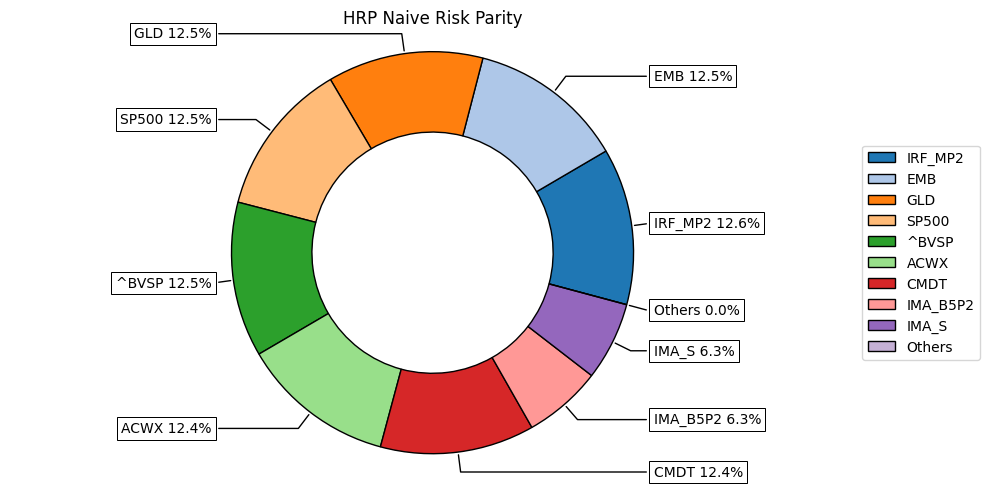

In [ ]:
# Building the portfolio object
port = rp.HCPortfolio(returns=log_train)

# Estimate optimal portfolio
model='HRP' # Could be HRP or HERC

# Maior Retorno - ward | ewma1 | gerber2 | ADD_Rel
# Maior Sharpe  - weighted | ewma1 | pearson | MV
# Menor DD      - centroid | ewma1 | abs_pearson | MDD

linkage = 'centroid' # Linkage method used to build clusters
covariance = 'hist'
codependence = 'gerber2' # Correlation matrix used to group assets in clusters
rm = 'SLPM' # Risk measure used, this time will be variance

rf = 0.095 # Risk free rate
max_k = 20 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
obj = 'Sharpe'
hist = True

w = port.optimization(
    model=model,
    codependence=codependence,
    covariance=covariance,
    obj=obj,
    rm=rm,
    rf=rf,
    linkage=linkage,
    max_k=max_k,
    leaf_order=leaf_order,
    hist=hist
)

# Plotting the composition of the portfolio
ax = rp.plot_pie(
    w=w,
    title='HRP Naive Risk Parity',
    others=0.05,
    nrow=30,
    cmap='tab20',
    height=5,
    width=10,
    ax=None
)

In [ ]:
portfolio_return = np.sum(raw_data * w.weights.T, axis=1)
#portfolio_return.index = portfolio_return.index.tz_localize('America/Sao_Paulo')

pf.create_full_tear_sheet(
    portfolio_return,
    live_start_date=live_date,
    benchmark_rets=raw_ibv['^BVSP']
)

KeyError: "[Timestamp('2008-04-02 00:00:00+0000', tz='UTC')] not in index"

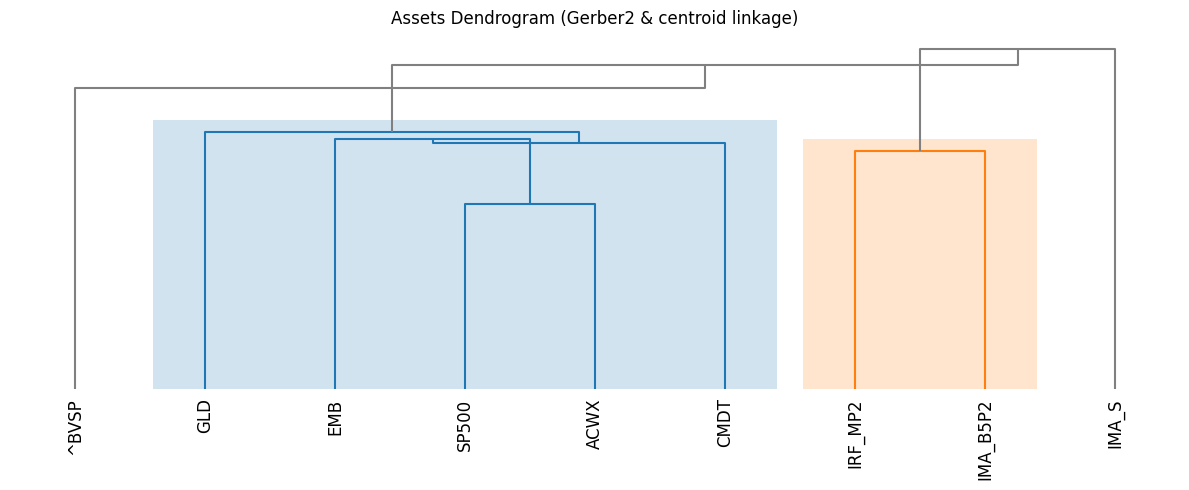

In [ ]:
############################################################
### Using All Period of Time to Optimize the Final Portfolio
############################################################

### Plotting Assets Clustering
ax = rp.plot_dendrogram(
    returns=log_data,
    codependence=codependence,
    linkage=linkage,
    k=None,
    max_k=20,
    leaf_order=True,
    ax=None
)

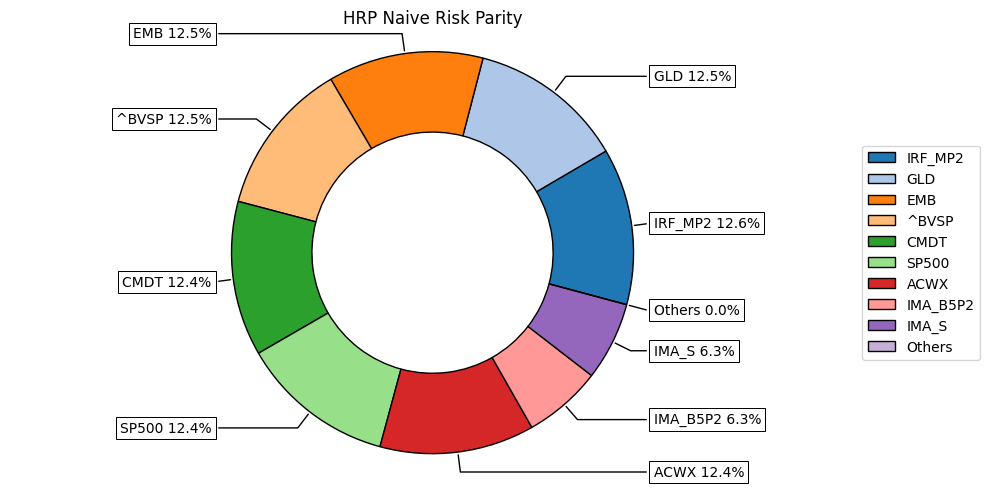

In [ ]:
# @title
# Building the portfolio object
port = rp.HCPortfolio(returns=log_data)

w = port.optimization(
    model=model,
    linkage=linkage,
    covariance=covariance,
    codependence=codependence,
    rm=rm,
    obj=obj,
    rf=rf,
    max_k=max_k,
    leaf_order=leaf_order,
    hist=hist
)

# Plotting the composition of the portfolio
ax = rp.plot_pie(
    w=w,
    title='HRP Naive Risk Parity',
    others=0.05,
    nrow=30,
    cmap='tab20',
    height=5,
    width=10,
    ax=None
)

Start date,2008-04-03
End date,2024-12-30
Total months,207
,Backtest
Annual return,12.13%
Cumulative returns,626.889%
Annual volatility,11.531%
Sharpe ratio,1.05
Calmar ratio,0.79
Stability,0.99
Max drawdown,-15.268%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.27,2008-10-08,2008-10-27,2009-01-02,63
1,13.38,2020-02-21,2020-03-18,2020-04-23,45
2,9.42,2021-12-30,2022-09-23,2023-07-26,410
3,7.86,2008-05-20,2008-08-18,2008-10-08,102
4,6.18,2018-09-19,2018-10-29,2019-02-14,107


Stress Events,mean,min,max
Lehman,0.11%,-2.03%,2.38%
US downgrade/European Debt Crisis,0.20%,-1.75%,1.90%
Fukushima,0.02%,-1.01%,1.12%
EZB IR Event,0.04%,-0.53%,1.35%
Sept08,0.21%,-2.03%,2.38%
2009Q1,-0.05%,-2.31%,1.68%
2009Q2,0.10%,-2.04%,2.54%
Flash Crash,0.18%,-0.19%,0.46%
Apr14,0.02%,-0.94%,0.95%
Oct14,-0.02%,-1.60%,1.86%


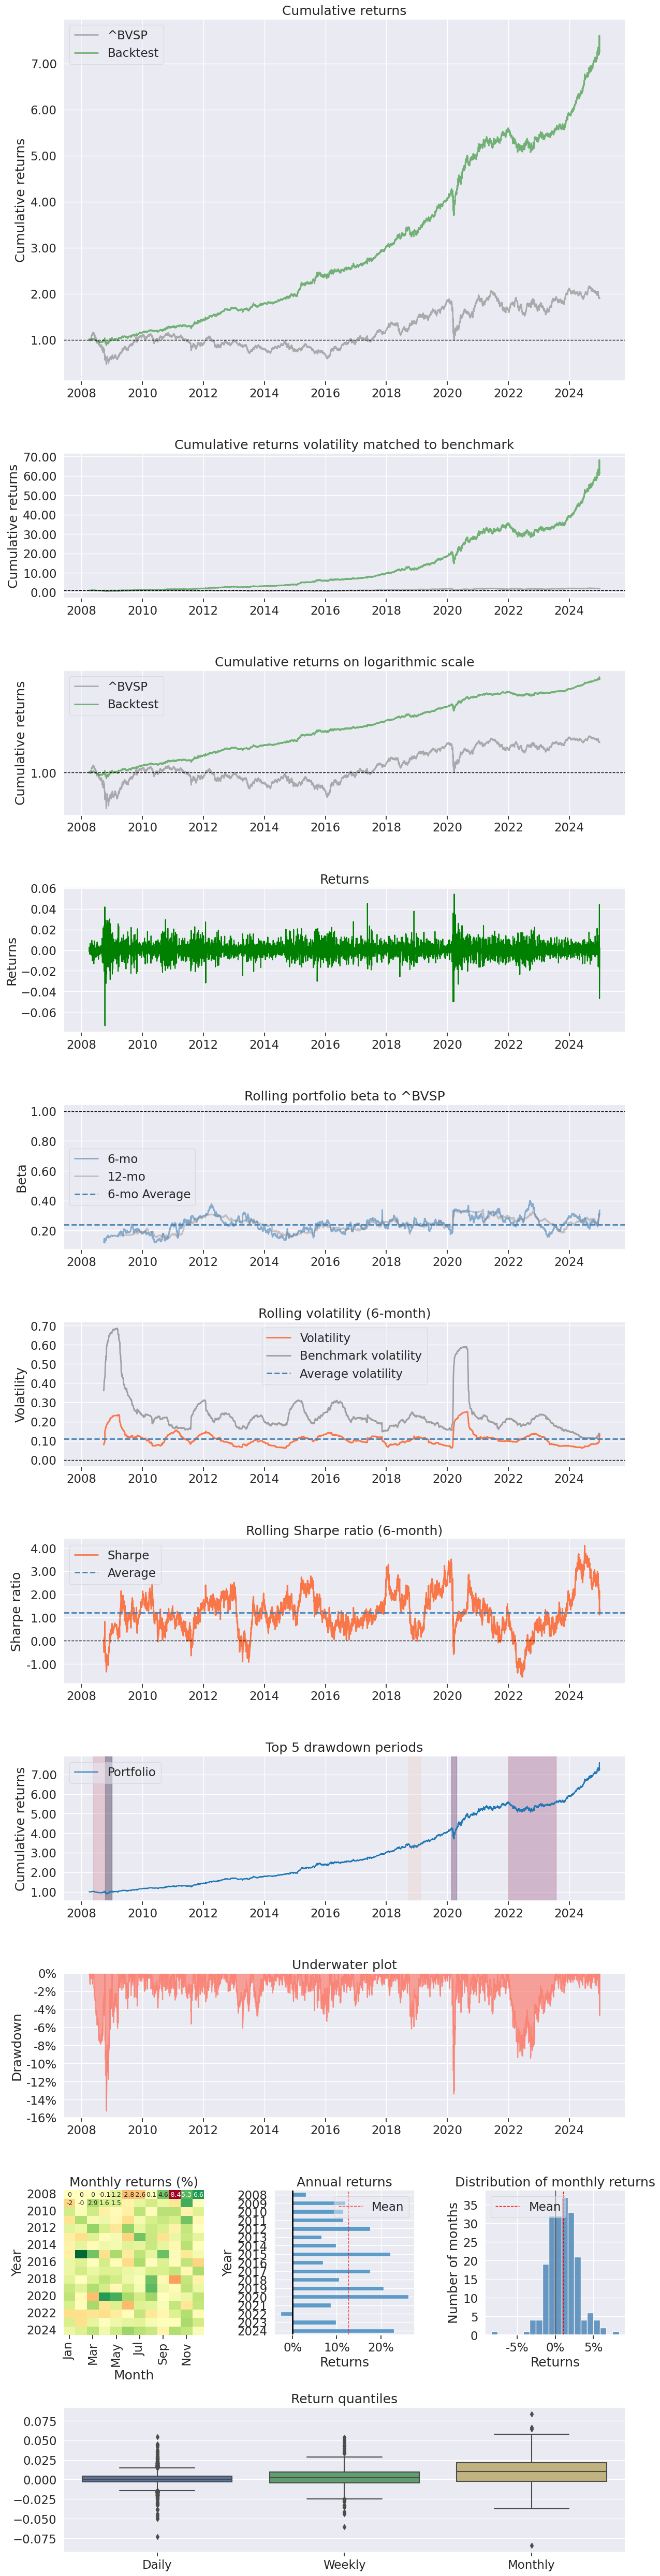

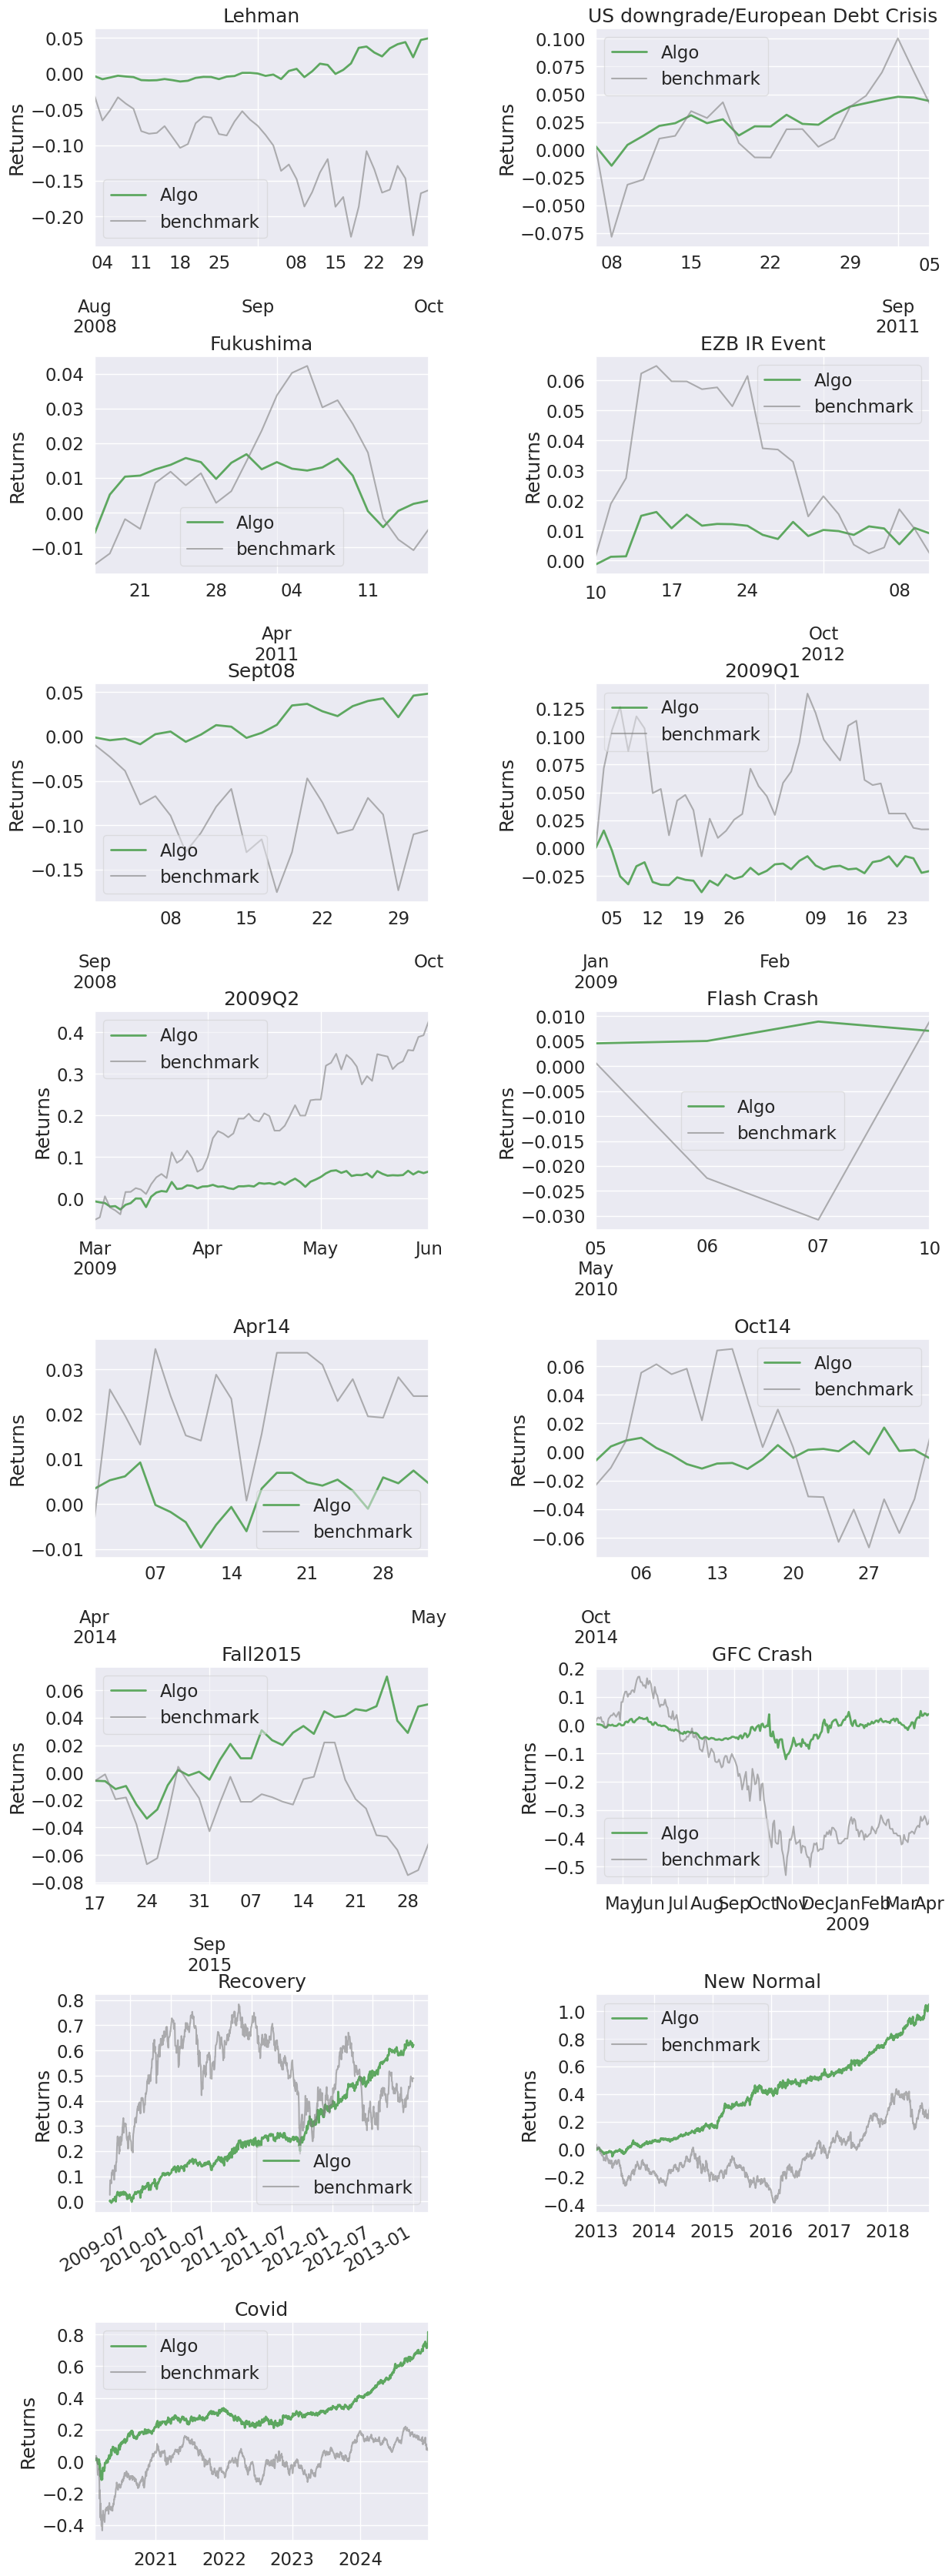

In [ ]:
# @title
portfolio_return = np.sum(raw_data * w.weights.T, axis=1)

pf.create_full_tear_sheet(
  portfolio_return,
  benchmark_rets=raw_ibv['^BVSP']
)

In [ ]:
# @title
savings = 20000

preco = data.tail(1).T
preco.columns = ['preco']

my_port = (
    pd.DataFrame(
      {
      'ticker': w.index,
      'pesos': round(w['weights'] * 100, 2),
      'valor': round(w['weights'] * savings, 1),
      }
    )
    .sort_values(by=['pesos'], ascending=False)
    .reset_index(drop=True)
)

my_port

,ticker,pesos,valor
0,IRF_MP2,12.600,2520.400
1,GLD,12.520,2503.900
2,EMB,12.490,2497.700
3,^BVSP,12.450,2490.000
4,CMDT,12.450,2489.800
5,SP500,12.450,2489.400
6,ACWX,12.440,2487.900
7,IMA_B5P2,6.300,1260.800
8,IMA_S,6.300,1260.100
